In [1]:
import numpy as np
import pandas as pd
import pickle 
import random
import matplotlib.pyplot as plt
import joblib
import requests
from bs4 import BeautifulSoup as bs
from datetime import date

In [2]:
import keras
from keras.layers import Dense, Flatten, Reshape, Input
from keras.layers import  Dense, Lambda, dot, Activation, concatenate, LSTM, BatchNormalization, TimeDistributed
from keras.models import Sequential, Model
from keras.callbacks import History 
from keras.layers import Activation, Dropout, Flatten, Dense

In [3]:
#Load scalers and data into memory 
scaler_x = joblib.load('scaler_x.pkl')
scaler_y = joblib.load('scaler_y.pkl')

#Format and get unqiue players 
df_scaled = pd.read_csv("Test.csv")
del df_scaled['Unnamed: 0']
lb = 5
players = df_scaled['Starters'].unique()


def format(df_scaled, lb):
  """
  format: takes a dataframe of players stat lines and returns a 3d array of rolling stats, 1d array of actual points
  and a 2d array of the opposing teams defensive stats

  param df_scaled: A dataframe that is normalized where each row is a players stat line in a given game. Score is for that game
  param lb: How many games in the past to include in one sample.
  """
  x_list = []
  y_list = []
  def_list = []

  for player in (players):
      #Grab only the games played by this player. Sort on data so past five games are correct
      ar_mid = df_scaled[df_scaled['Starters'] == player]
      ar_mid = ar_mid.sort_values(by='DATE')
      ar_mid = ar_mid.values

      #Need at least lb + games to have been played be the player in order to have lb # of games for x data any 1 more to predict
      if ar_mid.shape[0] < lb+1:
          pass
      else:
          for i in range(0, ar_mid.shape[0] - lb):
              x = ar_mid[i: i + lb, 2:-1]
              y = ar_mid[i + lb, -1]
              x_list.append(x)
              y_list.append(y)

              def_stats = ar_mid[i + lb, -6:-2]
              def_list.append(def_stats)

              
  x_data = np.stack(x_list)
  y_data = np.stack(y_list)
  def_data = np.stack(def_list)
  return x_data, y_data, def_data

x_data, y_data, def_stats = format(df_scaled, lb)
df_scaled

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.0 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


,Starters,DATE,MP,FG,FGA,FG%,3P,3PA,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,+/-,TS%,eFG%,3PAr,FTr,ORtg,DRtg,BPM,HCA,PTS_DEF,TRB_DEF,TOV_DEF,ORTG_DEF,DD_TD,Score
0,Al Horford,2018-10-16 00:00:00,0.461006,0.173913,0.159091,0.571,0.000000,0.041667,0.038462,0.034483,1.0,0.000000,0.173913,0.133333,0.08,0.0,0.4,0.750000,0.166667,0.128571,0.542857,0.403333,0.380667,0.143,0.017875,0.300000,0.854545,0.660670,1.0,0.448690,0.414997,0.352227,0.443884,0.0,0.241546
1,Michael Kidd-Gilchrist,2018-04-01 00:00:00,0.496665,0.260870,0.295455,0.462,0.000000,0.000000,0.153846,0.137931,1.0,0.076923,0.173913,0.166667,0.00,0.2,0.0,1.000000,0.333333,0.228571,0.257143,0.361333,0.308000,0.000,0.038500,0.386667,0.920000,0.659022,1.0,0.453222,0.414944,0.342817,0.448310,0.0,0.268116
2,Kemba Walker,2018-04-01 00:00:00,0.398409,0.086957,0.159091,0.286,0.071429,0.208333,0.192308,0.172414,1.0,0.000000,0.043478,0.033333,0.16,0.0,0.1,0.666667,0.000000,0.142857,0.342857,0.362000,0.238000,0.714,0.089250,0.296667,0.929091,0.655200,1.0,0.453222,0.414944,0.342817,0.448310,0.0,0.185990
3,Kyrie Irving,2018-10-16 00:00:00,0.446383,0.086957,0.318182,0.143,0.071429,0.333333,0.076923,0.068966,1.0,0.000000,0.173913,0.133333,0.28,0.0,0.0,0.750000,0.166667,0.100000,0.542857,0.156667,0.119333,0.571,0.017875,0.210000,0.870909,0.653091,1.0,0.448690,0.414997,0.352227,0.443884,0.0,0.222222
4,Dwight Howard,2018-04-01 00:00:00,0.398153,0.173913,0.159091,0.571,0.000000,0.000000,0.076923,0.172414,0.4,0.076923,0.391304,0.333333,0.00,0.1,0.1,0.916667,0.333333,0.142857,0.333333,0.362000,0.380667,0.000,0.089250,0.336667,0.910909,0.657968,1.0,0.453222,0.414944,0.342817,0.448310,0.5,0.280193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107979,Joe Ingles,2016-12-31 00:00:00,0.350693,0.130435,0.113636,0.600,0.214286,0.125000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.750000,0.000000,0.128571,0.476190,0.600000,0.600000,0.600,0.000000,0.313333,0.896364,0.658627,1.0,0.589423,0.469669,0.452303,0.508575,0.0,0.101449
107980,Trey Lyles,2016-12-31 00:00:00,0.271421,0.043478,0.113636,0.200,0.000000,0.125000,0.038462,0.068966,0.5,0.000000,0.173913,0.133333,0.08,0.0,0.0,0.916667,0.166667,0.042857,0.466667,0.170000,0.133333,0.600,0.050000,0.203333,0.885455,0.654277,1.0,0.589423,0.469669,0.452303,0.508575,0.0,0.115942
107981,Joe Johnson,2016-12-31 00:00:00,0.266290,0.043478,0.090909,0.250,0.000000,0.041667,0.000000,0.000000,0.0,0.000000,0.086957,0.066667,0.00,0.0,0.0,0.833333,0.500000,0.028571,0.504762,0.166667,0.166667,0.250,0.000000,0.110000,0.890909,0.647423,1.0,0.589423,0.469669,0.452303,0.508575,0.0,0.048309
107982,Raul Neto,2016-12-31 00:00:00,0.216008,0.130435,0.136364,0.500,0.000000,0.083333,0.076923,0.068966,1.0,0.000000,0.043478,0.033333,0.04,0.1,0.0,1.000000,0.333333,0.114286,0.523810,0.387333,0.333333,0.333,0.041625,0.413333,0.878182,0.662647,1.0,0.589423,0.469669,0.452303,0.508575,0.0,0.137681


In [4]:
index_list = []
for i in range(0, x_data.shape[0]):
  index_list.append(i)

random.shuffle(index_list)

x_final = np.zeros_like(x_data)
y_final = np.zeros_like(y_data)
for i in range(0,x_data.shape[0]):
  x_final[i,:,:] = x_data[index_list[0]]
  y_final[i] = y_data[index_list[0]]
  index_list.pop(0)

split = int(x_final.shape[0] * .8)

x_train = x_final[0:split, :,:]
y_train = y_final[0:split,]
x_test = x_final[split:x_final.shape[0],:,:]
y_test = y_final[split:y_final.shape[0]]

x_train = np.asarray(x_train).astype('float32')
x_test = np.asarray(x_test).astype('float32')
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

x_train.shape, y_train.shape, x_test.shape, y_train.shape

((83031, 5, 32), (83031,), (20758, 5, 32), (83031,))

In [5]:
history = History()
model = Sequential()

inp = Input(x_data[0].shape)
x = (LSTM(16, return_sequences=True))(inp)
x = (Dropout(.05))(x)
x = (BatchNormalization())(x)
x = (LSTM(32, return_sequences=True))(x)
x = (Dropout(.05))(x)
x = (LSTM(16))(x)
x = (Dropout(.05))(x)
out = (Dense(1, activation = 'relu'))(x)

model = Model(inputs = inp, outputs = out)
model.compile(
  optimizer='adam',
  loss='mean_squared_error'
)

model.summary()

model.fit(x_train, y_train,
          batch_size=100,
          epochs=5,
          verbose=1,
          shuffle = False,
          validation_data=(x_test, y_test),
          callbacks=[history])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 32)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 16)             3136      
_________________________________________________________________
dropout (Dropout)            (None, 5, 16)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 16)             64        
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 32)             6272      
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 32)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136  

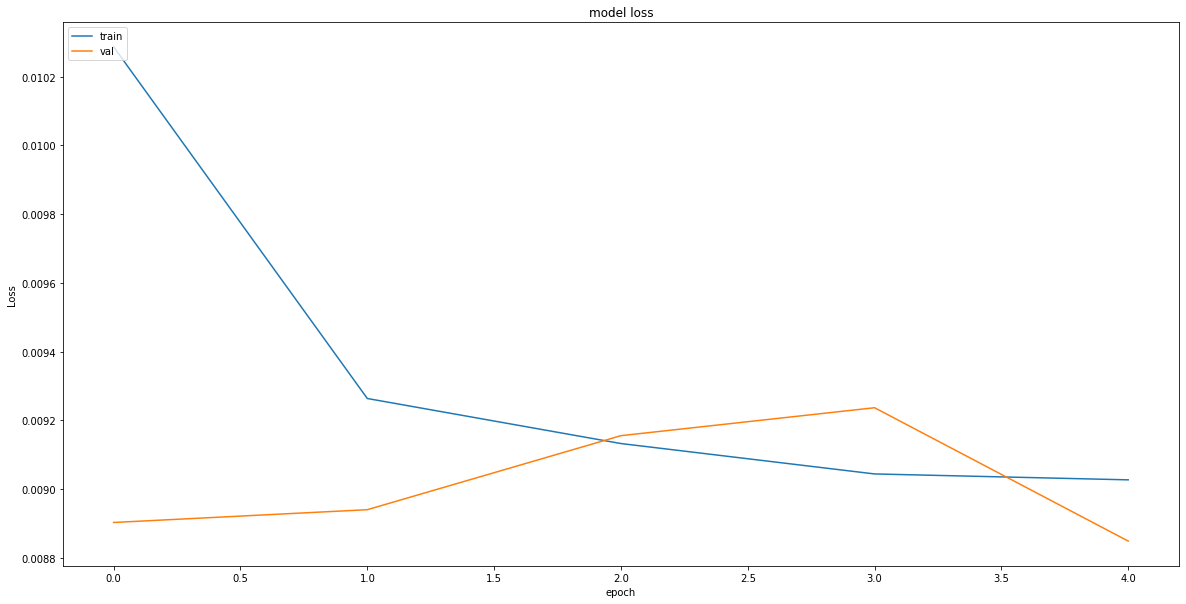

649/649 [==============================] - 1s 2ms/step - loss: 0.0088


0.008848373778164387

In [6]:
fig = plt.figure(figsize=(20,10))
ax = plt.subplot()

x = np.arange(0,len(history.history['loss']))

ax.plot(x,history.history['loss'])
ax.plot(x,history.history['val_loss'])


plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
model.evaluate(x_test, y_test)

In [7]:
from keras.models import model_from_json

model_json = model.to_json()

with open("MODEL.json", "w") as json_file:
      json_file.write(model_json)

model.save_weights("UP.h5")

In [8]:
df = pd.read_csv("Test.csv")
del df['Unnamed: 0']

In [9]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

co = 20

#Load Data, format, and scale
x_array, y_array, def_data = format(df, 5)
actual = scaler_y.inverse_transform((y_array.reshape(-1,1)))
x_array = np.asarray(x_array).astype('float32')

#Predict entire dataset and scale back
_preds = model.predict(x_array)
preds = scaler_y.inverse_transform(_preds)

#Create x data set
#Combination of defesne data and LSTM prediction
x = np.hstack((def_data, preds))

#Train test split accoring to intial model split
x_train = x[0:split,:]
y_train = actual[0:split,]
x_test = x[split:actual.shape[0],:]
y_test = actual[split:actual.shape[0]]

In [10]:
#Fit regressor and predict on test set
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 3, alpha = 10, n_estimators = 100)
xg_reg.fit(x_train,y_train)
preds_xgb = xg_reg.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, preds_xgb))
print("XGB RMSE: %f" % (rmse))

RF_reg = RandomForestRegressor()
RF_reg.fit(x_train, y_train)
preds_rf = RF_reg.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, preds_rf))
print("RF RMSE: %f" % (rmse))

pred_final = .5 * preds_xgb + .5 * preds_rf
rmse = np.sqrt(mean_squared_error(y_test, pred_final))
print("Final RMSE: %f" % (rmse))



[18:32:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB RMSE: 9.090290


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


RF RMSE: 9.366140
Final RMSE: 9.119006


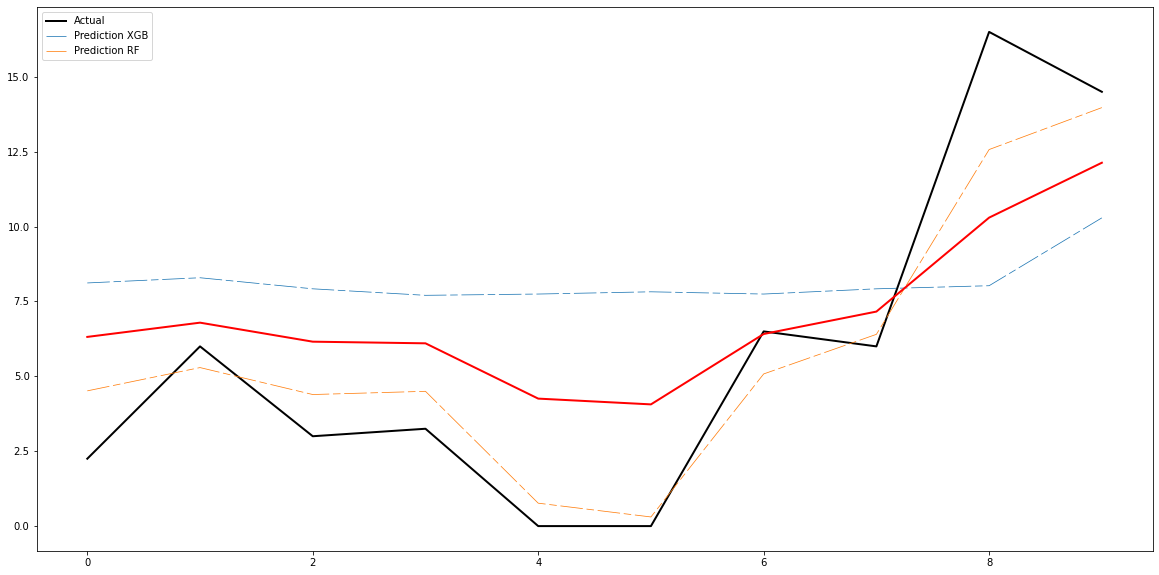

In [11]:
player = "Sindarius Thornwell"
df_player = df[df['Starters'] == player]
x_array, y_array, def_data = format(df_player, 5)

actual = scaler_y.inverse_transform((y_array.reshape(-1,1)))
x_array_LSTM = np.asarray(x_array).astype('float32')

_preds = model.predict(x_array_LSTM)
preds = scaler_y.inverse_transform(_preds)
x_array = np.hstack((def_data, preds))

preds = xg_reg.predict(x_array)
preds_rf = RF_reg.predict(x_array)


fig = plt.figure(figsize=(20,10))
ax = plt.subplot()

co = 10
ax.plot(actual[-co:], label = 'Actual', color = 'black', linewidth = 2)
ax.plot(preds[-co:], label = 'Prediction XGB', dashes=[30, 5, 10, 5], linewidth = .75)
ax.plot(preds_rf[-co:], label = 'Prediction RF', dashes=[30, 5, 10, 5], linewidth = .75)
ax.plot(.5*preds_rf[-co:] + .5*preds[-co:], color = 'red', linewidth = 2)
ax.legend()


In [12]:
def prediciton_func(team, opp):

  url_team = "https://www.basketball-reference.com/teams/{}/2021.html".format(team)
  html_text = requests.get(url_team).text
  team = bs(html_text)

  table = team.find_all('table', id = 'roster')
  df_team = pd.read_html(str(table))[0]
  home_players = df_team['Player']
  home_players.values

  pred_list = []
  for player in home_players:
    data = df_scaled[df_scaled['Starters'] == player].sort_values(by='DATE').tail(5)
    del data['Score'], data['Starters'], data['DATE']

    data = np.array([data.values])
    if data.shape != (1,5,32):
      pred_list.append(0)
    else:
      prediction = model.predict(data)
      prediction = scaler_y.inverse_transform(prediction)
      prediction

      last = def_df[def_df['TEAM'] == opp].sort_values('DATE_DEF')['PTS_DEF'].tail(1).values[0]

      if np.isnan(last):
        def_stats = def_df[def_df['TEAM'] == opp].sort_values('DATE_DEF').tail(2).values[0,4:-1]
      else:
        def_stats = def_df[def_df['TEAM'] == opp].sort_values('DATE_DEF').tail(1).values[0,4:-1]

      x_data = np.hstack((np.array([def_stats]), prediction))
      pred_final = xg_reg.predict(x_data)
      pred_final_rf = RF_reg.predict(x_data)
      pred = .5*pred_final[0] + .5*pred_final_rf[0]

      pred_list.append(pred)

  return home_players, pred_list


def_df = pd.read_csv("DEF.csv")
url = "https://www.basketball-reference.com/leagues/NBA_2021_games.html"
html_text = requests.get(url).text
games = bs(html_text)

table_rows = games.find_all('tr')
l = []
df_list = []
for tr in (table_rows[1:]):
    td = list(tr.find_all('td'))
    home = td[1].get("csk")
    away = td[3].get("csk")

    if home[4:12] == "20201225":
      home_team = home[0:3]
      away_team = away[0:3]
      
      home_players, home_preds = prediciton_func(home_team, away_team)
      away_players, away_preds = prediciton_func(away_team, home_team)

      df_mid = pd.DataFrame(home_players)
      df_mid['Preds'] = home_preds

      df_mid_away = pd.DataFrame(away_players)
      df_mid_away['Preds'] = away_preds

      df_concat = pd.concat([df_mid, df_mid_away])
      df_list.append(df_concat)
    
    else:
      pass

df_final = pd.concat(df_list)
df_final.head(20)
      

,Player,Preds
0,J.J. Redick,25.856537
1,Eric Bledsoe,32.579751
2,Lonzo Ball,29.386451
3,Zion Williamson,32.344585
4,Steven Adams,25.579797
5,Josh Hart,25.492655
6,Nickeil Alexander-Walker,14.683452
7,Nicolò Melli,14.118190
8,Jaxson Hayes,11.471204
9,Wenyen Gabriel,12.802454
